In [1]:
from __future__ import division
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import json
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
import string
import math
from dota_function_definitions import create_dota_dataframe2, getSynergyFactor, getWinRateArray, predictWinRate
from dota_function_definitions import getWinRateOpposingTeamArray, getAdvantageFactor, predictWinRateRefined, suggestHero

In [2]:
with open('heroes.txt', mode='r') as infile:
    reader = csv.reader(infile)
    heroDict = {rows[0]:rows[1] for rows in reader}

In [3]:
with open('automatchdetails_feb26_to_feb29.txt', 'r') as text:
    dotaString = text.read()

In [4]:
dotaString = string.replace(dotaString, '][', ', ')
matchDetailsJSON = json.loads(dotaString)

In [5]:
dotaFrame = create_dota_dataframe2(matchDetailsJSON)

In [6]:
dotaFrame.groupby('Game Mode').sum()['Match Counter']

Game Mode
1     14844
2       268
3       955
4      2583
5       291
12        4
13        7
16        2
18      707
20       32
22    18273
Name: Match Counter, dtype: int64

In [7]:
%matplotlib inline

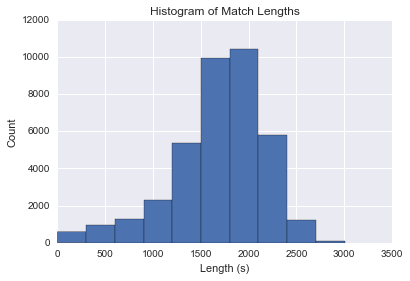

In [8]:
ax = dotaFrame['Match Length (s)'].hist()
ax.set(xlabel='Length (s)', ylabel='Count', title='Histogram of Match Lengths')

All pick (game mode 1) and ranked all pick (game mode 22) provide the most freedom in picking heroes. In either mode, any player can pick any hero, so we will restrict our model to these two game modes. We will also eliminate games that end in under 10 minutes as that is generally indicative of something else happening (e.g. a player quitting the game early).

In [9]:
dotaFrame = pd.concat([dotaFrame[dotaFrame['Game Mode']==1], dotaFrame[dotaFrame['Game Mode']==22]])

In [10]:
dotaFrame = dotaFrame[dotaFrame['Match Length (s)']>599]

Split data into a training set and a testing set. Training set determines model parameters and we test against the testing set.

In [11]:
dotaFrameTrain, dotaFrameTest = train_test_split(dotaFrame, test_size = 0.25, random_state = 0)

In [12]:
len(dotaFrameTest)

7998

In [13]:
len(dotaFrameTrain)

23994

In [14]:
winRateArray, matchCountArray = getWinRateArray(dotaFrameTrain)

[(0, 113),
 (1, 113),

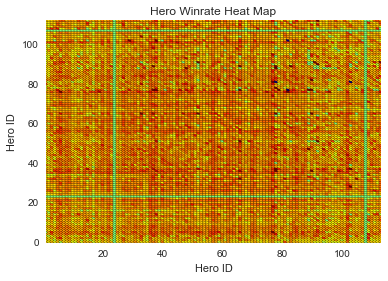

In [15]:
xCoordinate = range(1,114)*113
yCoordinate = range(1,114)*113
yCoordinate.sort()
zCoordinate = []
tempwrArray = list(winRateArray[1:])
for hero in tempwrArray:
    for i in range(1,114):
        zCoordinate.append(hero[i])
        
fig = plt.figure()
ax = fig.add_subplot(111)
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=min(zCoordinate), vmax=max(zCoordinate))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ax.scatter(xCoordinate, yCoordinate, c=scalarMap.to_rgba(zCoordinate))
ax.set(xlabel='Hero ID', xlim=[1,113], ylabel='Hero ID', ylim=[0,113], title='Hero Winrate Heat Map')

For the first iteration of this model, we compare the amount of synergy each team has by looking at winrates from past data. The team with the higher synergy is predicted to be the winner.

$$Synergy = \frac{\Sigma_{i=j} r_{ij}*a\log{N_{ij}} + \Sigma_{i\neq j} {r_{ij}*b\log{N_{ij}}}} {\Sigma_{i=j} a\log{N_{ij}} + \Sigma_{i\neq j} b\log{N_{ij}}}$$

$i,j \in$ Team Heroes, $r_{ii}$ = Hero Winrate, $r_{ij}$ = Pairwise Winrate, $N_{ij}$ = Number of Games for Pair

In [16]:
bParameter = np.linspace(0,30,61)
correctPredictions = []
for b in bParameter:
    correctPredictions.append(predictWinRate(dotaFrameTest, winRateArray, matchCountArray, b))

Best b: 0.5


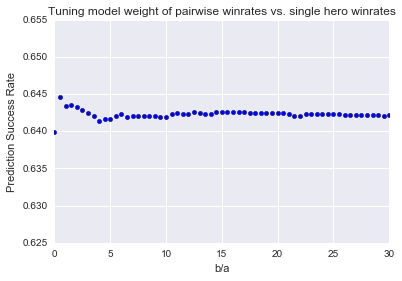

In [17]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(bParameter, correctPredictions)
ax2.set(xlabel='b/a', ylabel='Prediction Success Rate', xlim=[0,30])
ax2.set(title='Tuning model weight of pairwise winrates vs. single hero winrates')
print("Best b: %s" %(bParameter[correctPredictions.index(max(correctPredictions))]))

$$Advantage = \frac{\Sigma_{ij} d_{ij}\log{N_{ij}}} {\Sigma_{ij}\log{N_{ij}} }$$

$$d_{ij} = r_{ij} - (r_{ii} - r_{jj})$$

$i \in$ Team Heroes, $j ]in$ Enemy Heroes, $r_{ii}$ = Hero Winrate, $r_{ij}$ = Winrate of Hero i against Hero j, $N_{ij}$ = Number of Games for Pair

The model predicts victory for your team if: $Synergy_{YourTeam}Advantage_{YourTeam} > Synergy_{EnemyTeam}Advantage_{EnemyTeam}$

In [18]:
opposingWinRateArray, opposingMatchCountArray = getWinRateOpposingTeamArray(dotaFrameTrain)

In [19]:
correctPredictionsRefined = []
for b in bParameter:
    correctPredictionsRefined.append(predictWinRateRefined(dotaFrameTest, winRateArray, matchCountArray, opposingWinRateArray, opposingMatchCountArray, b, 1))

Best b: 1.0


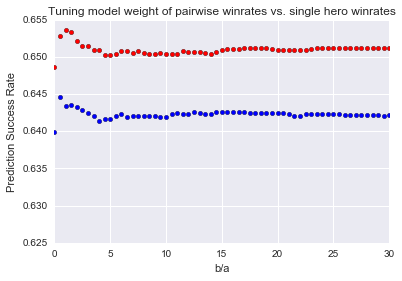

In [20]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.scatter(bParameter, correctPredictions)
ax3.scatter(bParameter, correctPredictionsRefined, c='red')
ax3.set(xlabel='b/a', ylabel='Prediction Success Rate', xlim=[0,30])
ax3.set(title='Tuning model weight of pairwise winrates vs. single hero winrates')
print("Best b: %s" %(bParameter[correctPredictionsRefined.index(max(correctPredictionsRefined))]))

We can also further tune the model by changing the amount of impact the advantage factor has.
Your team wins if: $Synergy_{YourTeam}Advantage_{YourTeam}^C > Synergy_{EnemyTeam}Advantage_{EnemyTeam}^C$

In [21]:
cParameter = np.linspace(0,4,41)
correctPredictionsRefined2 = []
for c in cParameter:
    correctPredictionsRefined2.append(predictWinRateRefined(dotaFrameTest, winRateArray, matchCountArray, opposingWinRateArray, opposingMatchCountArray, 1, c))

Best c: 1.0


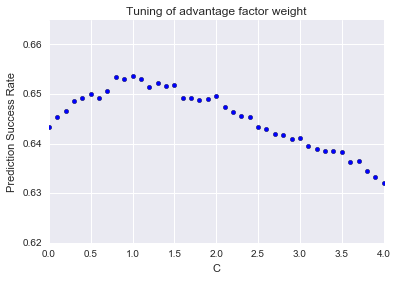

In [22]:
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.scatter(cParameter, correctPredictionsRefined2, c='blue')
ax5.set(xlabel='C', ylabel='Prediction Success Rate', xlim=[0,4])
ax5.set(title='Tuning of advantage factor weight')
print("Best c: %s" %(cParameter[correctPredictionsRefined2.index(max(correctPredictionsRefined2))]))

Using this model, we can also provide hero suggestions by finding heroes who both contribute to the team synergy and to the team advantage.

In [23]:
yourT = [77,102,48,20]
enemyT = [73,18,36,4,42]
suggestHero(yourT, enemyT, winRateArray, matchCountArray, opposingWinRateArray, opposingMatchCountArray, heroDict, b=22, c=1)

Your team: lycan, abaddon, luna, vengefulspirit
Enemy team: alchemist, sven, necrolyte, bloodseeker, skeleton_king
Top 3 recommended heroes: drow_ranger, luna, witch_doctor


[6, 48, 30]